<h1>SLP: LME, QTrans: LME, Precip: LME</h1>

In [4]:
AH_area = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/Diagnostics/DETRENDED_AH.Area.DJF.nc')[:,-106:]

In [5]:
psl_DJF = np.load('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_SLP_850-2005.npy')[:,-106:,:,:]
psl_lon = np.load('/data/ncresswell/cesm-cam5-lme/lon.npy')
psl_lat = np.load('/data/ncresswell/cesm-cam5-lme/lat.npy')

In [6]:
utransport = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/MoistureTransport/U.850hPa.DJF.nc')[:,-106:,:,:]
vtransport = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/MoistureTransport/V.850hPa.DJF.nc')[:,-106:,:,:]

In [7]:
precip_DJF = xr.open_dataarray('/data/ncresswell/cesm-cam5-lme/EnsembleMembers_DJF_Precip_850-2005_mmpermonth.nc')[:,-106:,:,:]

In [8]:
############################################      CALCULATION      ######################################################
extreme_percent         = 15

#Initialize anomaly arrays
precip_smallest_anomaly = np.empty([12,96,144])
precip_largest_anomaly = np.empty([12,96,144])
u_smallest_anomaly = np.empty([12,96,144])
u_largest_anomaly = np.empty([12,96,144])
v_smallest_anomaly = np.empty([12,96,144])
v_largest_anomaly = np.empty([12,96,144])
psl_largest_anomaly = np.empty([12,96,144])

#Initialize sifnificance testing containers 
precip_smallest_ttest = np.empty([12,96,144])
precip_largest_ttest = np.empty([12,96,144])

for i in range(1,13):
    
    precip_ensemble_member     = precip_DJF[i,:,:,:].values
    utransport_ensemble_member = utransport[i-1,:,:,:].values
    vtransport_ensemble_member = vtransport[i-1,:,:,:].values
    psl_ensemble_member        = psl_DJF[i,:,:,:]
    
    _,where_largest = get_extremes(series=AH_area[i,:],percent=extreme_percent,top=True)

    ###########################################     PRECIP ANOMALIES   ##############################################
    #in mm/month
    precip_largest_anomaly[i-1,:,:]  = precip_ensemble_member[where_largest,:,:].mean(axis=0)-precip_ensemble_member.mean(axis=0)
    precip_largest_ttest[i-1,:,:]    = ttest_ind(precip_ensemble_member,precip_ensemble_member[where_largest,:,:])[1]
    #######################################     U TRANSPORT ANOMALIES   ##########################################
    u_largest_anomaly[i-1,:,:]  = utransport_ensemble_member[where_largest,:,:].mean(axis=0)-utransport_ensemble_member.mean(axis=0)
    #######################################     V TRANSPORT ANOMALIES   ##########################################
    v_largest_anomaly[i-1,:,:]  = vtransport_ensemble_member[where_largest,:,:].mean(axis=0)-vtransport_ensemble_member.mean(axis=0)
    #########################################       PSL ANOMALIES       ###########################################
    psl_largest_anomaly[i-1,:,:] = psl_ensemble_member[where_largest,:,:].mean(axis=0)-psl_ensemble_member.mean(axis=0)
    
    

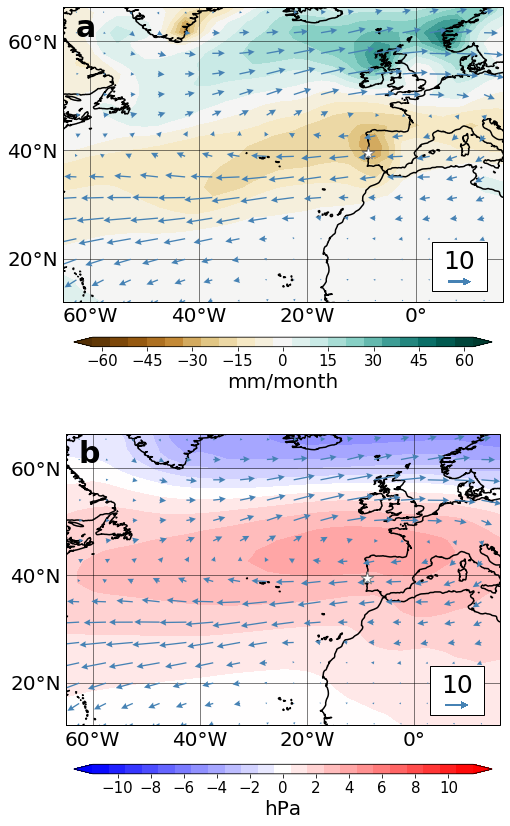

In [10]:
#############################################      PANEL 1       ########################################################

fig = plt.figure(figsize=(15,15))

#subplot 1, precip anomaly and qtrans
ax1=plt.subplot(2,1,1,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.set_extent([-65,16,12,60])
#gridlines for references
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='k', linestyle='-',zorder=0)
gl.xlocator = mticker.FixedLocator(np.arange(-100,40,20))
gl.ylocator = mticker.FixedLocator(np.arange(-20,81,20))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 20, 'color': 'k'}
gl.ylabel_style = {'size': 20, 'color': 'k'}

ax1.coastlines(linewidth = 1.5,
              resolution = '50m',
              color = 'k',zorder=0);
#add a cyclic point to the rainfall data
plotting_precip, plotting_lon = add_cyclic_point(precip_largest_anomaly.mean(axis=0),precip_DJF['lon'].values)
#now plot
im1 = ax1.contourf(plotting_lon,
             precip_DJF['lat'],
             plotting_precip,
             transform=ccrs.PlateCarree(),extend='both',cmap='BrBG',levels=np.arange(-2.1,2.2,.2)*30,zorder=-1)
qv1 = ax1.quiver(utransport['lon'].values[::2], 
               utransport['lat'].values[::2], 
               u_largest_anomaly.mean(axis=0)[::2,::2], 
               v_largest_anomaly.mean(axis=0)[::2,::2], 
               angles='xy',
               color="steelblue",
               scale=.2,
               width=.003,
               headwidth=5,
               transform=ccrs.PlateCarree());
ax1.scatter(-8.9, 39.5,s=175,
         color='w', edgecolor='grey', linewidth=1, marker='*',
         transform=ccrs.PlateCarree(),
         )

#draw background for quiver key
ax1.add_patch(mpatches.Rectangle(xy=[3, 14], width=10, height=9,
                                facecolor='white',
                                edgecolor='black',
                                alpha=1,
                                transform=ccrs.PlateCarree())
                 )
ax1.quiverkey(qv1,X=0.9, Y=.07, U=.01,label='10',fontproperties={'size':25},zorder=12.6)

cbar = plt.colorbar(im1,label='mm/month',orientation='horizontal',shrink=.5,pad=.09,aspect=40, ticks=np.arange(-2,2.1,.5)*30)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='mm/month',size=20)

ax1.text(x=.03,y=.9,
         s='a',
         fontsize=30,
         transform=ax1.transAxes,fontweight='bold')

#################################################      PANEL 2     ########################################################


#subplot 1, SLP anomaly and qtrans
ax2=plt.subplot(2,1,2,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.set_extent([-65,16,12,60])
#gridlines for references
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='k', linestyle='-',zorder=0)
gl.xlocator = mticker.FixedLocator(np.arange(-100,40,20))
gl.ylocator = mticker.FixedLocator(np.arange(-20,81,20))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 20, 'color': 'k'}
gl.ylabel_style = {'size': 20, 'color': 'k'}

ax2.coastlines(linewidth = 1.5,
              resolution = '50m',
              color = 'k',zorder=0);

#Large AH 
im2 = ax2.contourf(psl_lon,
                   psl_lat,
                   psl_largest_anomaly.mean(axis=0),
                   transform=ccrs.PlateCarree(),extend='both',cmap='bwr',levels=np.arange(-11.5,11.6,1),zorder=-1)
qv2 = ax2.quiver(utransport['lon'].values[::2], 
                 utransport['lat'].values[::2], 
                 u_largest_anomaly.mean(axis=0)[::2,::2], 
                 v_largest_anomaly.mean(axis=0)[::2,::2], 
                 angles='xy',
                 color="steelblue",
                 scale=.2,
                 width=.003,
                 headwidth=5,
                 transform=ccrs.PlateCarree());

ax2.scatter(-8.9, 39.5,s=175,
         color='w', edgecolor='grey', linewidth=1, marker='*',
         transform=ccrs.PlateCarree(),
         )
#draw background for quiver key
ax2.add_patch(mpatches.Rectangle(xy=[3, 14], width=10, height=9,
                                facecolor='white',
                                edgecolor='black',
                                alpha=1,
                                transform=ccrs.PlateCarree())
                 )
ax2.quiverkey(qv2,X=0.9, Y=.07, U=.01,label='10',fontproperties={'size':25},zorder=12.6)
ax2.text(x=.03,y=.9,
         s='b',
         fontsize=30,
         transform=ax2.transAxes,fontweight='bold')

cbar = plt.colorbar(im2,label='hPa',orientation='horizontal',shrink=.5,pad=.1,aspect=40,ticks=np.arange(-10,11,2))
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='hPa',size=20)

#Final touchups 
fig.subplots_adjust(wspace=.1,hspace=.1)

# plt.savefig('/home/ncresswell/Desktop/AzoresHigh_Nature/figure_files/revised/LargeAHComposites_LME_REVISED_8-22-21.png',dpi=120)
plt.savefig('/home/ncresswell/Desktop/AzoresHigh_Nature/figure_files/revised/LargeAHComposites_LME_REVISED_5-01-22.pdf',dpi=360)

In [1]:
%run AzoresHighProjectImports.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/DataAnalyzing.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/DataProcessing.py
%run /home/ncresswell/AzoresHighExpansion/MyFunctions/Plotting.py

import time
from scipy.interpolate import griddata

"""
This function will plot frequency of extreme events as reported by ERA-20C pressure data over a defined window 

USAGE: to use pass an index that is defined through time, and specify what the threshold is for extreme event using the
      'percent' perameter. 

"""

def running_bin_extremes(index=None, percent=20, window=11, time=np.arange(1850,2006), label_large = '',label_small = '',title = '',legend_loc=2, index_has_nan=False,ylim=None):

    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index_shape)
    
    running_bin_big, running_bin_small = get_bin_timeseries(index=index, percent=percent, window=window)
        
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(time,running_bin_big,color='red',linewidth=3,alpha=2,label=label_large);
    ax.plot(time,running_bin_small,color='blue',linewidth=3,alpha=10,label=label_small);
   
    #Alter Ticks and labels
    ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=20)
    ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=20)
    ax.set_ylabel('Number of Extreme Events',fontsize=25)
    
    ax.legend(fontsize=30,loc=legend_loc);
    ax.set_title(title,fontsize=35);
    
    return fig,ax

"""
This function offers the same functionality of the running_bin_extremes_era data but is altered to account for the CESM_LME
meaning it assumed the first dimension of the data is ensemble member number. 

usage: pass index defined along ensemble member and time. observe the default parameters used in the calculation and
       rendering of the plot and change if desired 
"""

def running_bin_extremes_lme(index=None, percent=20, window=11, label_large = '',label_small = '',title = '',legend_loc=2, index_has_nan=False,ylim=None):

    #initialize containers for running bin diagnostic 
    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index.shape)
    
    #iterate through ensemble members
    for e_mem in range(0,13):

        running_bin_big[e_mem,:],running_bin_small[e_mem,:] = get_bin_timeseries(index=index[e_mem,:], 
                                                                                 percent=percent, window=window)

    fig, ax = plt.subplots(figsize=(20,10))
        
    ax.plot(time,running_bin_big.mean(axis=0),color='red',linewidth=3,alpha=2,label=label_large);
    ax.plot(time,running_bin_small.mean(axis=0),color='blue',linewidth=3,alpha=10,label=label_small);
   
    #Alter Ticks and labels
    ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=20)
    ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=20)
    ax.set_ylabel('Number of Extreme Events',fontsize=25)
    
    ax.legend(fontsize=30,loc=legend_loc);
    ax.set_title(title,fontsize=35);
    
    return fig,ax

def get_bin_timeseries(index=None, percent=20, window=11):
    
    running_bin_big   = np.zeros(index.shape)
    running_bin_small = np.zeros(index.shape)
    
    #get list of extreme years
    _,where_largest  = get_extremes(series=index,percent=percent,top=True)
    _,where_smallest = get_extremes(series=index,percent=percent,bot=True)
    
    running_bin_big,_  = extremes_per_window(date_range=np.arange(0,index.size), \
                                                      dates_of_extremes=where_largest, \
                                                      window=window);
    running_bin_small,_= extremes_per_window(date_range=np.arange(0,index.size), \
                                                      dates_of_extremes=where_smallest, \
                                                      window=window);
    
    return running_bin_big, running_bin_small

def get_aha(filename, lon_name='lon',lat_name='lat',var_name='psl',lat_range=[10,52],lon_range=[-60,10],threshold=1021,conversion_factor=1/100,mf_dataset = False,return_psl=True):
    
    #load data
    if mf_dataset:
        psl = xr.open_mfdataset(filename,
                                decode_times=False,
                                decode_cf=False,
                                concat_dim='time')[var_name]
    else:
        psl = xr.open_dataset(filename)[var_name]
    #get seasonal average DJF, also center longitude
    psl_djf,centered_lon = fix_lon(seasonal_averages(psl.values,
                                                     season='DJF')*conversion_factor,
                                   psl[lon_name].values)
    #calculate AHA diagnostic
    ah = filter_lat_lon(data_unfiltered=filter_tresh(data_unfiltered=psl_djf,
                                                     below=True,
                                                     threshold=threshold),
                        lat=psl[lat_name].values,
                        lat_range=lat_range,
                        lon=centered_lon,
                        lon_range=lon_range)
    #find AHA
    aha = get_area_of_filtered_data(ah,lat=psl[lat_name].values,
                                    lon=centered_lon)
    if return_psl:
        return aha, psl_djf, centered_lon
    else:
        return aha  

def get_composite_fields(aha=None,precip_djf=None,uq_850hPa_djf=None,vq_850hPa_djf=None,psl_djf=None,extreme_percent=15):

    ###########################################     FIND EXTREME EVENTS    #########################################
    _,where_largest  = get_extremes(series=aha,percent=extreme_percent,top=True)
    _,where_smallest = get_extremes(series=aha,percent=extreme_percent,bot=True)

    ###########################################     PRECIP ANOMALIES   ##############################################
    precip_largest_anomaly  = precip_djf[where_largest,:,:].mean(axis=0)-precip_djf.mean(axis=0)
    #######################################     U TRANSPORT ANOMALIES   ##########################################
    uq_largest_anomaly  = uq_850hPa_djf[where_largest,:,:].mean(axis=0)-uq_850hPa_djf.mean(axis=0)
    #######################################     V TRANSPORT ANOMALIES   ##########################################
    vq_largest_anomaly  = vq_850hPa_djf[where_largest,:,:].mean(axis=0)-vq_850hPa_djf.mean(axis=0)
    ###########################################     PSL ANOMALIES   ###############################################
    psl_largest_anomaly  = psl_djf[where_largest,:,:].mean(axis=0)-psl_djf.mean(axis=0)
    
    return precip_largest_anomaly,uq_largest_anomaly,vq_largest_anomaly, psl_largest_anomaly

def get_baseproj(ax=None,show_lon=False,show_lat=False):

    ax.set_global()
    ax.set_extent([-65,16,12,60])
    
    #gridlines for references
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                       linewidth=.5, color='k', linestyle='-',zorder=0)
    gl.xlocator = mticker.FixedLocator(np.arange(-100,40,20))
    gl.ylocator = mticker.FixedLocator(np.arange(-20,81,20))
    
    if show_lon:
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 20, 'color': 'k'}
    else:
        gl.xlabels_bottom = False
        
    if show_lat:
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 20, 'color': 'k'}
    else:
        gl.ylabels_right = False
    
    gl.xlabels_top = False
    gl.ylabels_left = False

    ax.coastlines(linewidth = 1,
                  resolution = '50m',
                  color = 'k',zorder=0);
    
    return ax
    
def plot_precip(ax=None,lon=None,lat=None,precip=None,conversion=1,add_cp_lon=True):
    
    if add_cp_lon:
        new_precip,new_lon = add_cyclic_point(data=precip,coord=lon)
        im = ax.contourf(new_lon,lat,new_precip*conversion,
                      transform=ccrs.PlateCarree(),
                      extend='both',
                      cmap='BrBG',
                      levels=np.arange(-63,66,6)*conversion,zorder=-1)
    else:
        im = ax.contourf(lon,lat,precip*conversion,
                          transform=ccrs.PlateCarree(),
                          extend='both',
                          cmap='BrBG',
                          levels=np.arange(-63,66,6)*conversion,zorder=-1)
    return ax,im

def plot_psl(ax=None,lon=None,lat=None,psl=None,conversion=1,add_cp_lon=True):
    
    if add_cp_lon:
        new_psl,new_lon = add_cyclic_point(data=psl,coord=lon)
        im = ax.contourf(new_lon,lat,new_psl*conversion,
                         transform=ccrs.PlateCarree(),
                         extend='both',
                         cmap='bwr',
                         levels=np.arange(-11.5,11.6,1),
                         zorder=-1)
    else:
        im = ax.contourf(lon,lat,psl*conversion,
                         transform=ccrs.PlateCarree(),
                         extend='both',
                         cmap='bwr',
                         levels=np.arange(-11.5,11.6,1),
                         zorder=-1)
    return ax,im

def plot_qtrans(ax=None,lon=None,lat=None,qu=None,qv=None,skip=2,legend=False):
    
    vec = ax.quiver(lon[::skip], 
                    lat[::skip], 
                    qu[::skip,::skip], 
                    qv[::skip,::skip], 
                    angles='xy',
                    color="steelblue",
                    scale=.2,
                    width=.003,
                    headwidth=5,
                    transform=ccrs.PlateCarree());
    if legend:
        #draw background for quiver key
        ax.add_patch(mpatches.Rectangle(xy=[-63, 56], width=32, height=8,
                                    facecolor='white',
                                    edgecolor='black',
                                    alpha=1,
                                    transform=ccrs.PlateCarree())
                     )

        ax.quiverkey(qv2,X=0.23, Y=.85, U=.01,label='10 $g*m*kg^{-1}*s^{-1}$',fontproperties={'size':15},zorder=12.6)
    return ax,vec

def get_values(x,y,xs,ys,data):
    return data[np.where(ys==y)[0][0],np.where(xs==x)[0][0]]

def get_interpolated_grid(lon_data=None,lat_data=None,data=None,lon_interp=np.arange(0,360,2),lat_interp = np.arange(-90,90,2)):
    
    #dafine existing fields as points and values 
    points = np.array(np.meshgrid(lat_data,lon_data)).T.reshape(-1,2)
    values = np.empty([points.shape[0]])
    for i in range(0,points.shape[0]):
        values[i] = get_values(points[i,1],points[i,0],lon_data,lat_data,data)

    #perform interpolation with new grid 
    lat_interp_grid,lon_interp_grid = np.meshgrid(lon_interp,lat_interp)
    return griddata(points,values,(lon_interp_grid,lat_interp_grid),method = 'linear')
    
def mm2mmd(precip):

    precip_data = precip.values

    #january
    precip_data[np.arange(0,precip_data.shape[0],12),:,:]=precip_data[np.arange(0,precip_data.shape[0],12),:,:]/31
    #feb
    precip_data[np.arange(1,precip_data.shape[0],12),:,:]=precip_data[np.arange(1,precip_data.shape[0],12),:,:]/28
    #mar
    precip_data[np.arange(2,precip_data.shape[0],12),:,:]=precip_data[np.arange(2,precip_data.shape[0],12),:,:]/31
    #april
    precip_data[np.arange(3,precip_data.shape[0],12),:,:]=precip_data[np.arange(3,precip_data.shape[0],12),:,:]/30
    #may
    precip_data[np.arange(4,precip_data.shape[0],12),:,:]=precip_data[np.arange(4,precip_data.shape[0],12),:,:]/31
    #june
    precip_data[np.arange(5,precip_data.shape[0],12),:,:]=precip_data[np.arange(5,precip_data.shape[0],12),:,:]/30
    #july
    precip_data[np.arange(6,precip_data.shape[0],12),:,:]=precip_data[np.arange(6,precip_data.shape[0],12),:,:]/31
    #aug
    precip_data[np.arange(7,precip_data.shape[0],12),:,:]=precip_data[np.arange(7,precip_data.shape[0],12),:,:]/31
    #sep
    precip_data[np.arange(8,precip_data.shape[0],12),:,:]=precip_data[np.arange(8,precip_data.shape[0],12),:,:]/30
    #oct
    precip_data[np.arange(9,precip_data.shape[0],12),:,:]=precip_data[np.arange(9,precip_data.shape[0],12),:,:]/31
    #nov
    precip_data[np.arange(10,precip_data.shape[0],12),:,:]=precip_data[np.arange(10,precip_data.shape[0],12),:,:]/30
    #dec
    precip_data[np.arange(11,precip_data.shape[0],12),:,:]=precip_data[np.arange(11,precip_data.shape[0],12),:,:]/31

    return precip_data

            
    